<font size='5'> <center> <u>**Playing Tick-Tack-Toe with RL Agents**</u></center></font>

In [59]:
import numpy as np

This section is an example implementation of Figure 1.1, "A sequence of tic-tac-toe moves," on page 10 of the book *Reinforcement Learning*. Most of the time, the model moves greedily, and occasionally, the model performs an exploratory move.

In [60]:
from typing import List, Dict, Tuple

def choose_move(avail_moves: Tuple[int], current_state: Tuple[int], 
                states_and_values: Dict[Tuple[int], float], explore_rate=0.1) -> int:
    
    # explore_rate determine how likely RL agent will explore a new random move
    explore_mode = np.random.choice([1, 0], p=[explore_rate, 1-explore_rate])

    # if 'explore_mode' is selected, then randomly place on a free spot on chess board
    if explore_mode == 1:
        return np.random.choice(avail_moves)
    
    # otherwise, we play based on best
    max_val = np.NINF
    action = None

    for move in avail_moves:
        # consult history move scores to select the best possible move
        state_key = tuple([*current_state, move])
        move_val = states_and_values.get(state_key, 0)

        if move_val > max_val:
            max_val = move_val
            action = move
    
    return action


Now we benchmark against 2 scenario to test whether the `choose_move` function behave correctly.

Scenario 1: 
```python3
states_and_values = {(1): 0.1, (1, 5): 0.9, (2):5, (1, 6): 3}
current_state = [1]
avail_moves = [2, 3, 4, 5, 6, 7, 8, 9]
```
The function is expected to choose move 6, because historical state `(1, 6)` yeilds highest value of 3.


Scenario 2:
```python3
states_and_values = {(1): 0.1, (2):5, (2, 3, 1): 7, (2, 3, 9): 4}
current_state = [2, 3]
avail_moves = [1, 4, 5, 6, 7, 8, 9]
```
The function is expected to choose move 1, since (2, 3, 1) yeilds highest value of 7.

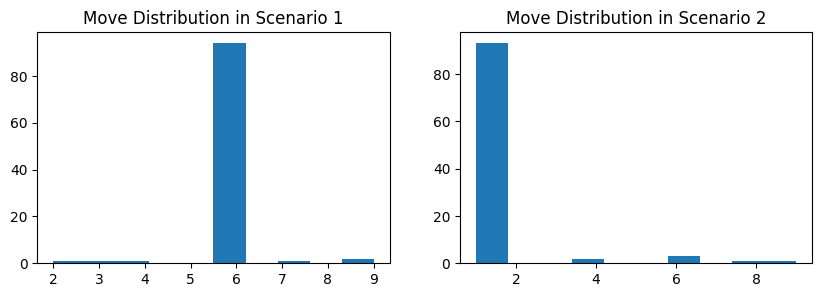

In [61]:
import matplotlib.pyplot as plt

# Scenario 1
states_and_values1 = {(1): 0.1, (1, 5): 0.9, (2):5, (1, 6): 3}
current_state1 = [1]
avail_moves1 = [2, 3, 4, 5, 6, 7, 8, 9]
actual_moves1 = [choose_move(avail_moves1, current_state1, states_and_values1) for _ in range(100)]

# Scenario 2
states_and_values2 = {(1): 0.1, (2):5, (2, 3, 1): 7, (2, 3, 9): 4}
current_state2 = [2, 3]
avail_moves2 = [1, 4, 5, 6, 7, 8, 9]
actual_moves2 = [choose_move(avail_moves2, current_state2, states_and_values2) for _ in range(100)]

# plot results
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].hist(actual_moves1)
ax[0].set_title('Move Distribution in Scenario 1')
ax[1].hist(actual_moves2)
ax[1].set_title('Move Distribution in Scenario 2')
plt.show()

Page 9 of the book presents the value estimation formula as illustrated below. Here, $V(S_t)$ denotes the estimated value of state $t$, and $\alpha$ is a small positive fraction called the <u>*step size parameter*</u> (also referred to as the <u>*learning rate*</u>). This update rule is an example of the <u>*temporal-difference*</u> learning method.

$$
V(S_t) \leftarrow V(S_t) + \alpha \left[ V(S_{t+1}) - V(S_t) \right] 
$$

The implementation uses the Q-Learning algorithm, which involves the Q-function described below:

$$ 
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ R(s, a) + \gamma \max(Q(s', a')) - Q(s, a) \right] 
$$

Here, $Q(s, a)$ estimates the value of taking action $a$ in state $s$. It is updated by taking the temporal difference $\max(Q(s', a')) - Q(s, a)$. The temporal difference is obtained by calculating the difference between the maximum value of an optimal action $a'$ and the value of current action $a$. $\gamma$ is called the discount rate, which is used to balance immediate and future rewards.

In [62]:
def give_reward(states_and_values: Dict[Tuple[int], float], game_states: Tuple[Tuple[int]],
                reward: float, alpha=0.5, gamma=0.1) -> Dict[Tuple[int], float]:
    
    # Ensure the last state gets the immediate reward
    last_state = game_states[-1]
    if last_state not in states_and_values:
        states_and_values[last_state] = 0.0
    states_and_values[last_state] += alpha * (reward - states_and_values[last_state])
    
    # Start from the second last state and propagate the values backwards
    for i in range(len(game_states) - 2, -1, -1):
        state = game_states[i]
        next_state = game_states[i + 1]
        
        # If the state is not in the dictionary, initialize it
        if state not in states_and_values:
            states_and_values[state] = 0.0
        if next_state not in states_and_values:
            states_and_values[next_state] = 0.0
        
        # Update the value of the current state
        states_and_values[state] += alpha * (
            gamma * states_and_values[next_state] - states_and_values[state]
        )
    
    return states_and_values

Now we create a game simulation classes to simulate the game

In [63]:
from typing import Literal, Tuple
from abc import abstractmethod
from enum import Enum
import os

StrategyType = Literal['random'] | Literal['rl']


class GameResult(Enum):
    WIN = 0
    LOSE = 1
    DRAW = 2


class Player:
    def __init__(self, symbol: str):
        self.symbol = symbol
        self.history = [] # note: index is game number and values are game result

    @abstractmethod
    def play(self, avail_moves: Tuple[int], current_state: Tuple[int]) -> int:
        """
        Determines the next move in a game given the current state of the board.

        Args:
            avail_moves (Tuple[int]): A tuple of integers representing the indices of available moves on the game board.
            current_state (Tuple[int]): A tuple of integers representing the indices of the currently occupied spots on the game board.

        Returns:
            int: The index of the next move selected by the player or agent.
        """
        pass

    @abstractmethod
    def on_game_end(self, game_states: Tuple[Tuple[int]], result: GameResult):
        """
        Callback method to be invoked when the game finishes.

        Args:
            game_states (Tuple[Tuple[int]]): A tuple of tuples representing the sequence of game states from the beginning to the end of the game. Each inner tuple represents the state of the game board at a specific point in time.
            result (GameResult): An enumeration indicating the outcome of the game.
        """
        pass


class DumbPlayer(Player):
    """
    This player just play random moves
    """
    def __init__(self, symbol: str):
        super().__init__(symbol)

    def play(self, avail_moves: Tuple[int], current_state: Tuple[int]) -> int:
        return np.random.choice(avail_moves)

    def on_game_end(self, game_states: Tuple[Tuple[int]], result: GameResult):
        """
        This player sleeps when game ends LOL
        """
        self.history.append(result.value)


class Game:
    def __init__(self):
        self.reset_game()
        self.player1: Player = None
        self.player2: Player = None
        self.starts_with_player1 = True
        
    def reset_game(self):
        self.board = {i: ' ' for i in range(1, 10)}
        self.avail_moves = list(range(1, 10))
        self.current_state = []
        self.game_states = []
        
    def simulate(self, print_board=False):
        winner = None

        for _ in range(1, 10):
            # end the game earlier if winner has found
            if winner is not None:
                break

            if print_board:
                os.system('clear')
                self.print_board()

            player = self.player1 if self.starts_with_player1 else self.player2
            move = player.play(self.avail_moves, self.current_state)
            if move not in self.avail_moves:
                raise ValueError("Invalid move")
        
            self.avail_moves.remove(move)
            self.current_state.append(move)
            self.game_states.append(tuple(self.current_state))

            self.board[move] = player.symbol                
            self.starts_with_player1 = not self.starts_with_player1
            winner = self.check_winner()

        final_game_states = tuple(self.game_states)
        if winner is None:
            self.player1.on_game_end(final_game_states, GameResult.DRAW)
            self.player2.on_game_end(final_game_states, GameResult.DRAW)
        elif winner == self.player1.symbol:
            self.player1.on_game_end(final_game_states, GameResult.WIN)
            self.player2.on_game_end(final_game_states, GameResult.LOSE)
        else:
            self.player1.on_game_end(final_game_states, GameResult.LOSE)
            self.player2.on_game_end(final_game_states, GameResult.WIN)

        if print_board:
            os.system('clear')
            self.print_board()
            
    def print_board(self):
        b = self.board
        print(f' {b[1]} | {b[2]} | {b[3]} ')
        print('---|---|---')
        print(f' {b[4]} | {b[5]} | {b[6]} ')
        print('---|---|---')
        print(f' {b[7]} | {b[8]} | {b[9]} ')
        
    def check_winner(self):
        winning_combinations = [
            (1, 2, 3), (4, 5, 6), (7, 8, 9), # Rows
            (1, 4, 7), (2, 5, 8), (3, 6, 9), # Columns
            (1, 5, 9), (3, 5, 7)             # Diagonals
        ]
        for combo in winning_combinations:
            a, b, c = combo
            if self.board[a] == self.board[b] == self.board[c] and self.board[a] != ' ':
                return self.board[a]
        return None


# Test
dumb_player1 = DumbPlayer('O')
dumb_player2 = DumbPlayer('X')
game = Game()
game.player1 = dumb_player1
game.player2 = dumb_player2
game.simulate()
game.print_board()
print(f"winner: {game.check_winner()}")

 X | X | O 
---|---|---
 O | O | X 
---|---|---
 O | X | O 
winner: O


The game is successfully simulated! Now, let's implement player with reinforcement learning ability that learns from previous matches. 

Cost of RL player: 14781


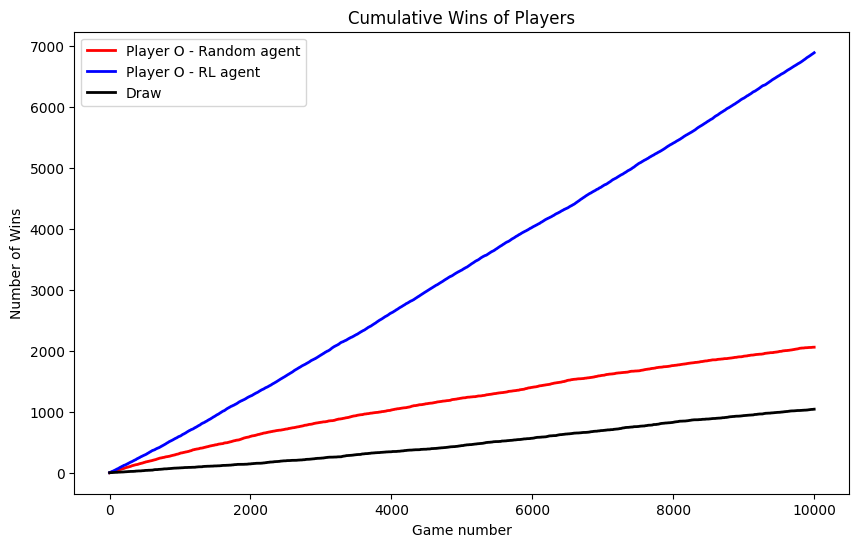

In [64]:
from typing import Tuple


class RLPlayer(Player):
    def __init__(self, symbol: str, reward: float, explore_rate=0.1, alpha=0.2, gamma=0.9):
        super().__init__(symbol)
        self.reward = reward
        self.explore_rate = explore_rate
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount rate
        self.memory = dict() # stores states_and_values for prediction

    def play(self, avail_moves: Tuple[int], current_state: Tuple[int]) -> int:
        return choose_move(avail_moves, current_state, self.memory, self.explore_rate)

    def on_game_end(self, game_states: Tuple[Tuple[int]], result: GameResult):
        if result == GameResult.WIN:
            reward = self.reward
        elif result == GameResult.LOSE:
            reward = -self.reward
        else:
            reward = self.reward / 2

        self.memory = give_reward(self.memory, game_states, reward, self.alpha, self.gamma)
        self.history.append(result.value)


iterations_number = 10000

player1 = RLPlayer('O', 1)
player2 = DumbPlayer('X')
game = Game()
game.player1 = player1
game.player2 = player2
starts1 = True
for _ in range(iterations_number):
    game.simulate()
    starts1 = not starts1
    game.reset_game()
    game.starts_with_player1 = starts1

print(f"Cost of RL player: {len(player1.memory)}")


x = np.arange(1, iterations_number + 1)
wins_rl = np.cumsum([1 if x == 0 else 0 for x in player1.history])
wins_dumb = np.cumsum([1 if x == 0 else 0 for x in player2.history])
draws = np.cumsum([1 if x == 2 else 0 for x in player1.history])

plt.figure(figsize = (10, 6))
plt.plot(x, wins_dumb, color = 'r', linewidth = 2, label = 'Player O - Random agent')
plt.plot(x, wins_rl, color = 'b', linewidth = 2, label = 'Player O - RL agent')
plt.plot(x, draws, color = 'k', linewidth = 2, label = 'Draw')

plt.title('Cumulative Wins of Players')
plt.xlabel('Game number')
plt.ylabel('Number of Wins')
plt.legend()
plt.show()

Compare with human

In [65]:
from typing import Tuple


class HumanPlayer(Player):
    def __init__(self, symbol: str):
        super().__init__(symbol)

    def play(self, avail_moves: Tuple[int], current_state: Tuple[int]) -> int:
        move = int(input(f"Enter your move {self.symbol} (available moves: {avail_moves}): "))
        return move
    
    def on_game_end(self, game_states: Tuple[Tuple[int]], result: GameResult):
        self.history.append(result.value)


game = Game()
game.player1 = player1
game.player2 = HumanPlayer('X')
game.simulate(print_board=True)

   |   |   
---|---|---
   |   |   
---|---|---
   |   |   
   |   |   
---|---|---
   |   |   
---|---|---
 O |   |   
   | X |   
---|---|---
   |   |   
---|---|---
 O |   |   
   | X |   
---|---|---
 O |   |   
---|---|---
 O |   |   
   | X | X 
---|---|---
 O |   |   
---|---|---
 O |   |   
 O | X | X 
---|---|---
 O |   |   
---|---|---
 O |   |   
